# What is DNet (Drought Network)?
a. stein 8.30.2023

Let's spend some time talking about the `DroughtNetwork`. In this tutorial we'll cover:
- what is a drought network?
- how to create a drought network
- how to plot a drought network
- how to manipulate a drought network
- how to return to nonbinary values

I'm assuming basic knowledge with Python3 in this tutorial and will not be going over how to read/write code. If you have not gone through `tutorial.ipynb` first, I recommend checking that out first for the motivation.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import xarray as xr

import sys
# add the path to ndrought to your system path
sys.path.append('../../')
import ndrought.drought_network as dnet
import ndrought.plotting as ndplot

/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/drought_network.py:17: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## What is a drought network?

A drought network is a [directed graph](https://en.wikipedia.org/wiki/Directed_graph), a grouping of various objects called **nodes** with the relationships between them denoted by lines/arrows called **edges**. A directed graph specifically has direction in its edges. We use this in the `DroughtNetwork` to preserve the direction of time.

## How to create a drought network

We'll learn more as we work with the `DroughtNetwork`, so let's make a simple example using cellular automata:

### Setup test case

Following is how we perform [cellular automata](https://en.wikipedia.org/wiki/Cellular_automaton)

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

Setup a test case for it

In [3]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
ca_matrix_5x5 = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

And now plot what we get

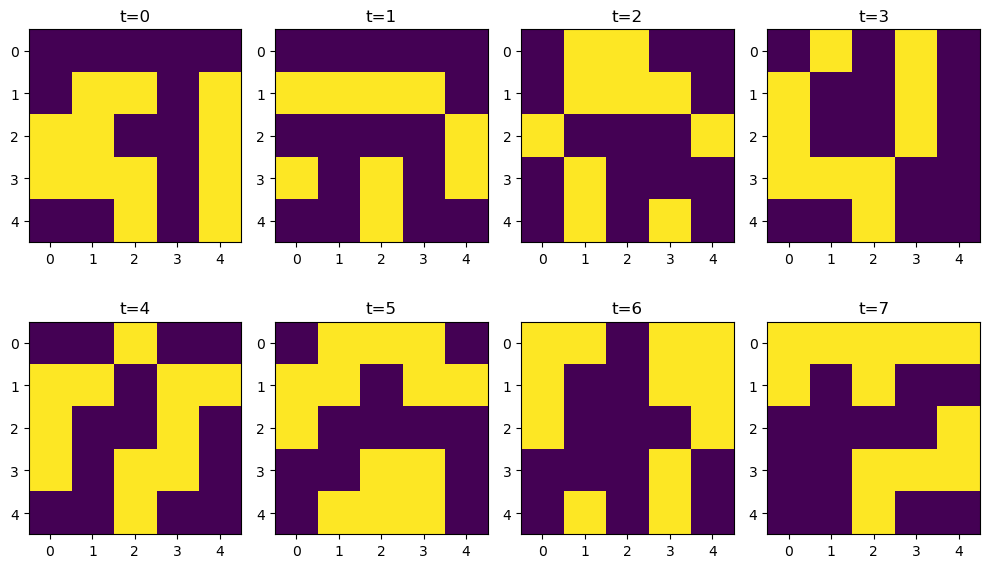

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

ca_series_5x5 = []
plot_matrix = ca_matrix_5x5

for i, ax in enumerate(axs.ravel()):
    ca_series_5x5.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(f't={i}')

ca_series_5x5 = np.array(ca_series_5x5)

plt.tight_layout()

Here we have psuedo-drought data, where yellow indicates "drought" and purple indicates "no drought" states.

To create a drought network, all we need is to plug the array of data we have into our constructor.

In [5]:
ca_net_5x5 = dnet.DroughtNetwork(ca_series_5x5, name="5x5 Cellular Automata")

Creating Network: 5x5 Cellular Automata: 100%|██████████| 8/8 [00:00<00:00, 230.93it/s]


Let's take a closer look at the constructor:

In [6]:
dnet.DroughtNetwork?

Init signature:
dnet.DroughtNetwork(
    data,
    threshold=1,
    area_threshold=0,
    name='drought_network',
)
Docstring:      <no docstring>
Init docstring:
Drought network for organizing events.

Parameters
----------
data
    Expecting zeroth dimension to be temporal
    while the first and second dimension are
    spatial.
threshold (optional)
    What value to set as the cutoff for drought/
    no-drought. Defaults as 1.
area_threshold (optional)
    How many grid cells to set as a minimum 
    threshold for how big a drought blob must be.
    Defaults as 0 for no threshold.
name: str (optional)
    What to call the drought network. Defaults as
    'drought_network'
File:           /pool0/data/steinjao/drought/drought_impact/ndrought/drought_network.py
Type:           type
Subclasses:     

So we've taken advantage of the naming, but there are a few other hidden features we can access. We can look at the `spawn_time` and any `notes` that are also incorporated with the network for metadata

In [7]:
ca_net_5x5.spawn_time

'31-08-2023 16:24:18'

In [8]:
print(ca_net_5x5.notes)
ca_net_5x5.notes = "This is an example of our drought network"
print(ca_net_5x5.notes)

Put notes in here
This is an example of our drought network


So we have those, let's take a look at how what we have represents the plots above

The network is ultimately organized by an adjacency dictionary, similar to an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix), except stored as a Python dictionary. The useful thing about dictionaries is that they preserve direction, allowing us to retain which direction time flows.

In [9]:
ca_net_5x5.adj_dict

{0: [2, 3, 4],
 1: [2],
 2: [5],
 3: [],
 4: [],
 5: [7],
 6: [],
 7: [8],
 8: [9, 10],
 9: [11, 12],
 10: [12, 13],
 11: [14],
 12: [14, 15],
 13: [],
 14: [],
 15: []}

We can read this as the node on the left side of the colon points to the nodes on the right side of the colon. Let's look at what nodes 0 and 1 are

In [10]:
print(ca_net_5x5.nodes[0])
print(ca_net_5x5.nodes[1])

time: 0, id: 0, futures: [2, 3, 4]
time: 0, id: 1, futures: [2]


We can see now that this refers to the two drought blobs present in the first time frame, `t=0`, and that one blob splits into blobs 2, 3, and 4 while the other blob merges with blob 2 created. A good exercise is to write out which blobs are which in the image using the adjacency dictionary printed above.

## How to plot a drought network

For smaller networks we can plot our drought network to see the connections that have formed. I'm going to show two ways this can be done

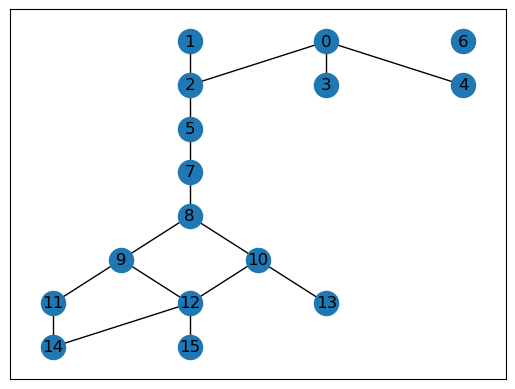

In [11]:
# use our script to get networkx
# topography and positions
topog, pos = ca_net_5x5.get_nx_network()

nx.draw_networkx(topog, pos)

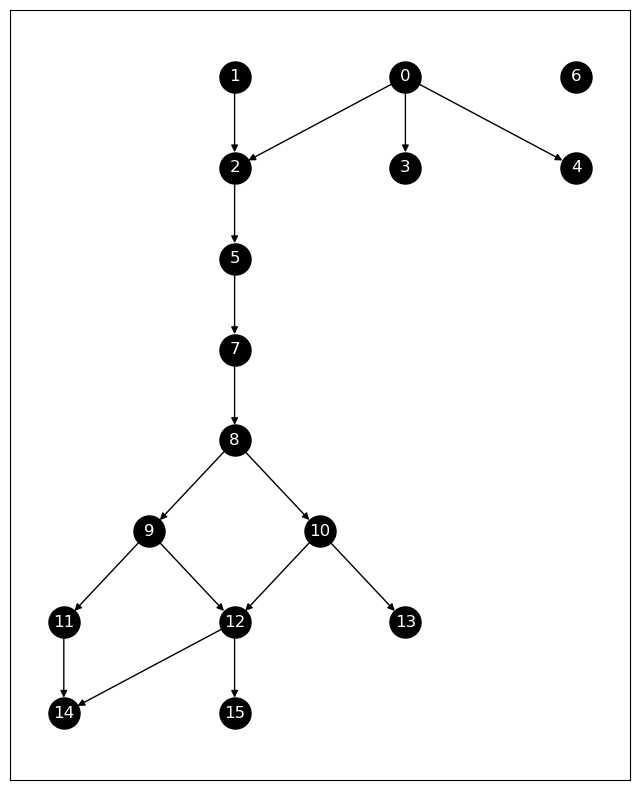

In [12]:
fig, ax = plt.subplots(figsize=(8,10))

# create a directed graph object from 
# the adjacency dictionary
dg = nx.DiGraph(ca_net_5x5.adj_dict)

nx.draw_networkx(dg, nx.drawing.nx_agraph.graphviz_layout(dg, prog= 'dot'), with_labels=True, font_color='white', node_color='k', ax=ax, node_size=500, font_size=12)

Both will yield the same results, but knowing both can be helpful to realize that whenever we traverse the network, we're ultimately traversing the adjacency dictionary.

If you haven't done so yet, go through and prove to yourself that the adjacency dictionary and this graph are the same thing. See how we have 0 pointing to 2, 3, and 4 again while 1 points to 2, showing it's merger with one of node 0's splits.

We can even get the underlying array back out if we so desire to plot and show that it's the same:

In [13]:
ca_net_5x5.to_array?

Signature: ca_net_5x5.to_array(id=None, start_time=None, end_time=None, adj_dict=None)
Docstring:
Converts the network into a 3-D array.

Parameters
----------
id, (optional): int
    If you would like to select out an id thread at the
    same time, this can be given to use 
    get_chronological_future_thread to time slice through.
start_time, (optional): int
    What time to start the slice at, inclusive. If None
    is given, then the time of the first node in the
    DroughtNetwork is used.
end_time, (optional): int
    What time to end the slice at, inclusive. If None is
    given, then the time of the last node in the 
    DroughtNetwork is used.
adj_dict, (optional): dict
    Use an alternative adjacency dictionary to the
    whole network. Defaults to using whole network if None
    is given.

Returns
-------
np.array
    First dimension is time, second and third are lat/lon. The
    array is only binary values based no the threshold originally
    given to the network.
File: 

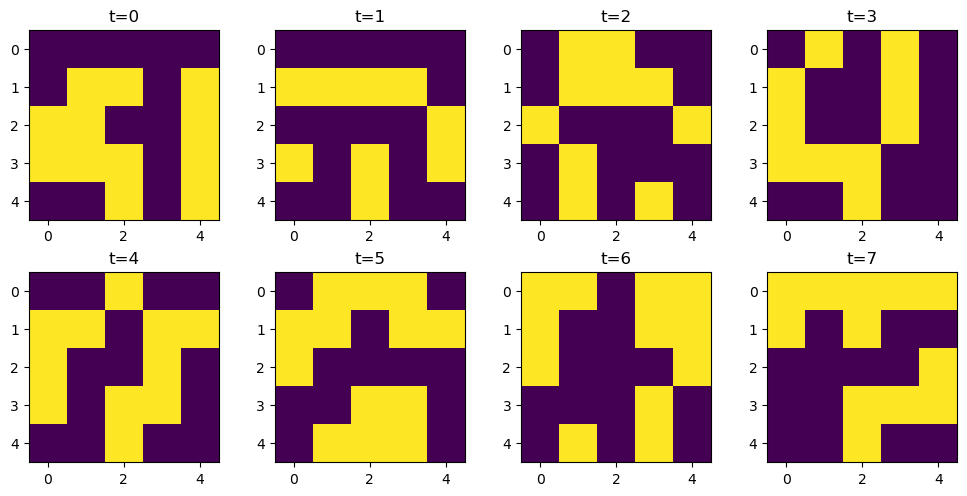

In [14]:
ca_array_5x5 = ca_net_5x5.to_array()

fig, axs = plt.subplots(2 , 4, figsize=(10,5))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(ca_array_5x5[i, :, :])
    ax.set_title(f't={i}')

plt.tight_layout()

Again, feel free to play with the various ways you can slice the data

## How to manipulate a drought network

Remember how the network is ultimately an adjacency dictionary with more details? Now we're going to mess with that adjacency dictionary. 

First if I want to pull out a thread, I can use `get_chronological_future_thread` by giving an id such as 5 here

In [15]:
thread_5 = ca_net_5x5.get_chronological_future_thread(5)

Now let's make the adjacency dictionary that would result from this

In [16]:
thread_5_id = [node.id for node in thread_5]

adjacency_dict = ca_net_5x5.filter_adj_dict_by_id(id_filter=thread_5_id)

In [17]:
adjacency_dict

{5: [7],
 7: [8],
 8: [9, 10],
 10: [12, 13],
 9: [11, 12],
 13: [],
 12: [14, 15],
 11: [14],
 14: [],
 15: []}

Now we can plot the graph again

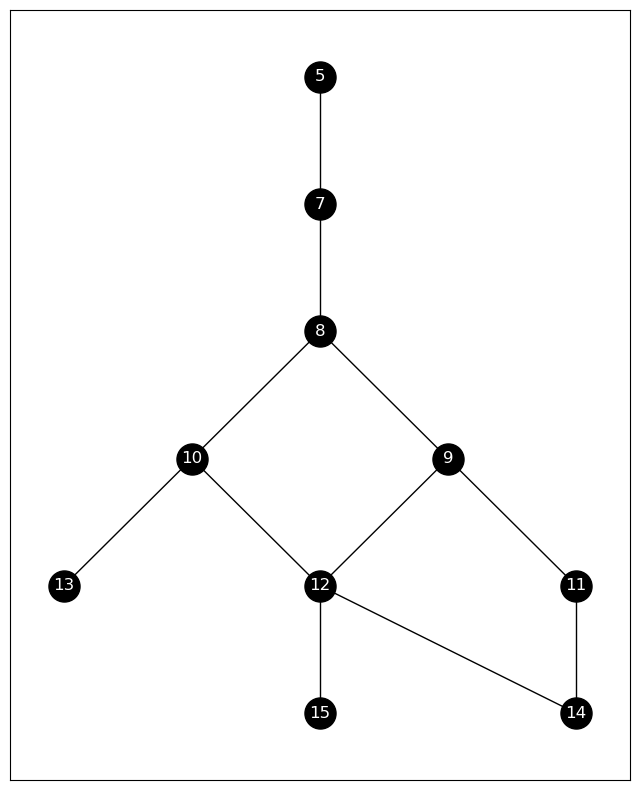

In [18]:
fig, ax = plt.subplots(figsize=(8,10))

G = nx.Graph(adjacency_dict)
nx.draw_networkx(G, nx.drawing.nx_agraph.graphviz_layout(G, prog= 'dot'), with_labels=True, font_color='white', node_color='k', ax=ax, node_size=500, font_size=12)

Notice how we cut off everything before 5? Note that while the graph may be a slightly different orientation due to the adjacency dictionary being a slightly different orientation, the values are still the same.

Well let's also see how we can simply do this with a list of ids to plot instead of a specific thread:

In [19]:
plot_ids = [0, 2, 3, 4, 9, 11, 14, 10, 13]

adjacency_dict = ca_net_5x5.filter_adj_dict_by_id(id_filter=plot_ids)

In [20]:
adjacency_dict

{0: [2, 3, 4],
 2: [],
 3: [],
 4: [],
 9: [11],
 11: [14],
 14: [],
 10: [13],
 13: []}

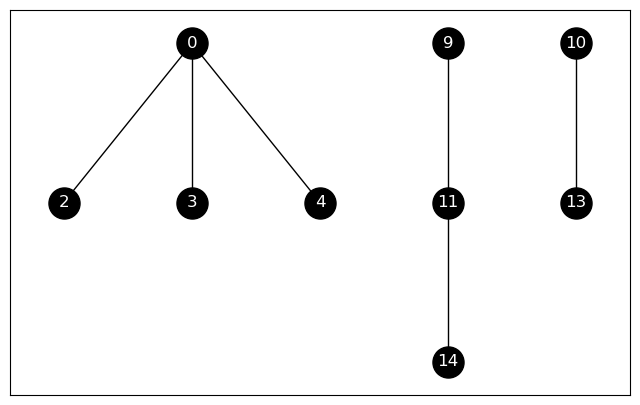

In [21]:
fig, ax = plt.subplots(figsize=(8,5))

G = nx.Graph(adjacency_dict)
nx.draw_networkx(G, nx.drawing.nx_agraph.graphviz_layout(G, prog= 'dot'), with_labels=True, font_color='white', node_color='k', ax=ax, node_size=500, font_size=12)

Now these are all well and good examples of manipulating the graphs, but these graphs aren't exactly the drought network, just representations of them. So let's then see how we can use these adjacency dictionaries to slice through our `DroughtNetwork`.

In [22]:
plot_ids = [0, 2, 3, 4, 9, 11, 14, 10, 13]

adjacency_dict_filtered = ca_net_5x5.filter_adj_dict_by_id(id_filter=plot_ids)

In [23]:
adjacency_dict_filtered

{0: [2, 3, 4],
 2: [],
 3: [],
 4: [],
 9: [11],
 11: [14],
 14: [],
 10: [13],
 13: []}

In [24]:
filtered_array = ca_net_5x5.to_array(adj_dict=adjacency_dict_filtered)
filtered_array.shape

(8, 5, 5)

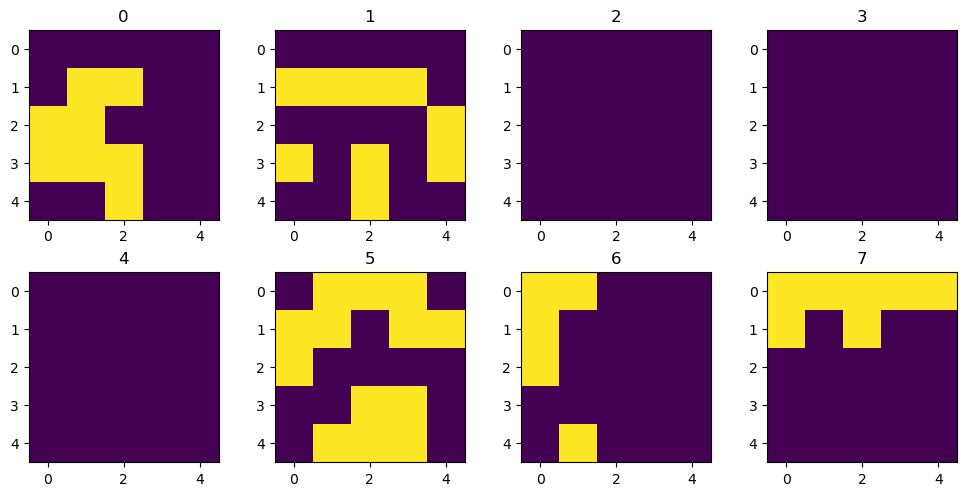

In [25]:
fig, axs = plt.subplots(2,4, figsize=(10,5))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(filtered_array[i,:,:])
    ax.set_title(i)

plt.tight_layout()

Now we see how we can use the adjacency matrix to pull out various events, which is where it is useful as a slicing argument in various functions.

## How to return to non-binary values

Now for a little lesson in masking. Here you'll need to have ran `tutorial.ipynb` first to have the appropriate data available.

In [26]:
spi180d_dnet = dnet.DroughtNetwork.unpickle('spi180d_dnet.pickle')

Recall that in `tutorial.ipynb` we plotted this network and saw just how big it is. Let's show that we can use our slicing to get out a part of the data.

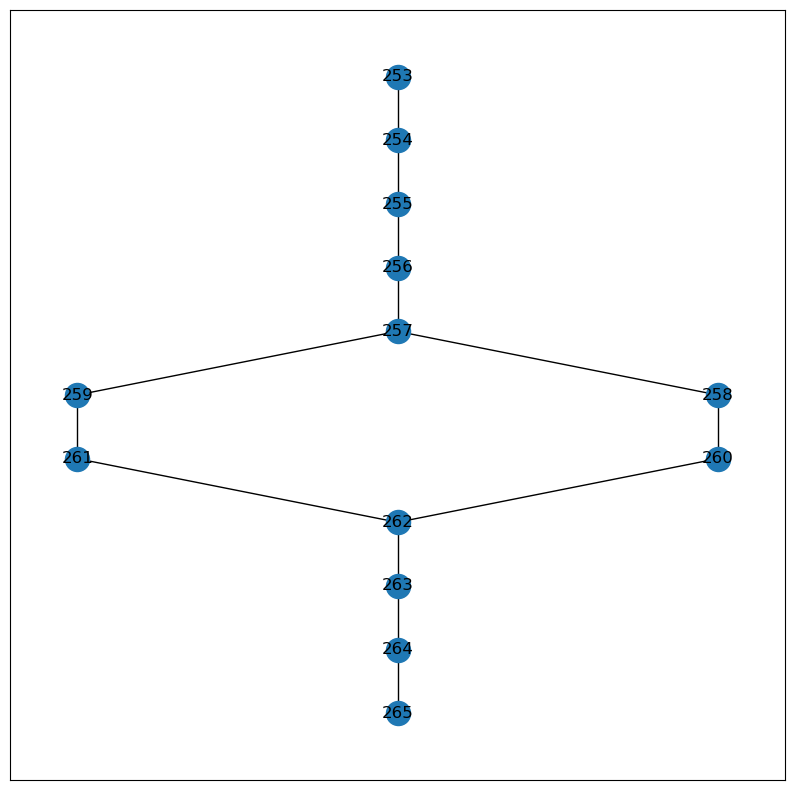

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
topog, pos = spi180d_dnet.get_nx_network(id=253)
nx.draw_networkx(topog, pos, ax=ax)

In [28]:
select_array = spi180d_dnet.to_array(id=253)
# let's double check the shape of this array
select_array.shape

(11, 153, 196)

In [29]:
spi180d_data = xr.open_dataset('spi180d_tutorial.nc')
spi180d_data

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 188, day: 1533)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 2000-01-05 2000-01-10 ... 2020-12-30
Data variables:
    crs      int64 ...
    spi      (day, lat, lon) float32 ...

Notice how we have different horizontal & vertical coordinate lengths compared to our array we just got out. That's because we didn't use lat/lon but x/y for our data that we gave the drought network, so we need to use the same data we gave it when masking.

In [30]:
spi180d_data_xy = xr.open_dataarray('spi180d_usdmcat_EPSG5070.nc')
spi180d_data_xy

<xarray.DataArray 'spi' (time: 1533, y: 153, x: 196)>
[45971604 values with dtype=float32]
Coordinates:
  * x        (x) float64 -2.211e+06 -2.207e+06 ... -1.541e+06 -1.538e+06
  * y        (y) float64 3.207e+06 3.203e+06 3.2e+06 ... 2.686e+06 2.682e+06
  * time     (time) datetime64[ns] 2000-01-05 2000-01-10 ... 2020-12-30
Attributes:
    units:              
    description:        Standardized Precipitation Index
    long_name:          spi180d
    standard_name:      spi180d
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    Clipping:           original data was clipped to Washington using http://...
    coordinates:        lon lat
    grid_mapping:       crs

Now the only bit we need to account for is that we have only a sliver of the time dimension, so we need to figure out what times to pull.

In [31]:
thread_253 = spi180d_dnet.get_chronological_future_thread(id=253)
thread_253

[time: 571, id: 253,
 time: 572, id: 254,
 time: 573, id: 255,
 time: 574, id: 256,
 time: 575, id: 257,
 time: 576, id: 259,
 time: 576, id: 258,
 time: 577, id: 261,
 time: 577, id: 260,
 time: 578, id: 262,
 time: 579, id: 263,
 time: 580, id: 264,
 time: 581, id: 265]

We can see that our times range from 571 to 581, which is 11 times if we include starting/stopping times which matches our array.

In [32]:
spi180d_data_xy_select = spi180d_data_xy.isel(time=slice(571,581+1))
spi180d_data_xy_select

<xarray.DataArray 'spi' (time: 11, y: 153, x: 196)>
[329868 values with dtype=float32]
Coordinates:
  * x        (x) float64 -2.211e+06 -2.207e+06 ... -1.541e+06 -1.538e+06
  * y        (y) float64 3.207e+06 3.203e+06 3.2e+06 ... 2.686e+06 2.682e+06
  * time     (time) datetime64[ns] 2007-11-01 2007-11-06 ... 2007-12-21
Attributes:
    units:              
    description:        Standardized Precipitation Index
    long_name:          spi180d
    standard_name:      spi180d
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    Clipping:           original data was clipped to Washington using http://...
    coordinates:        lon lat
    grid_mapping:       crs

Let's look at what each of our arrays gives us.

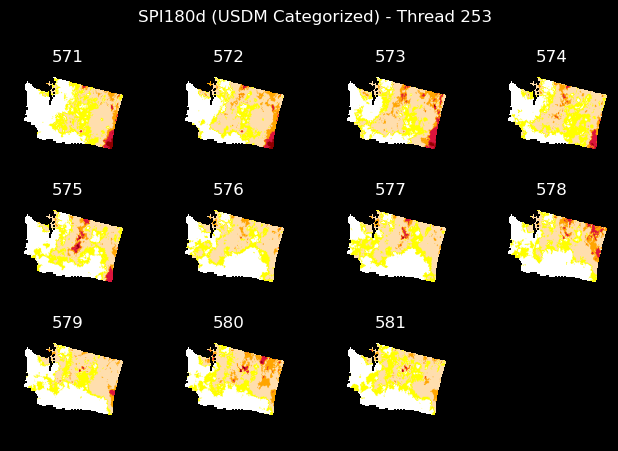

In [33]:
fig, axs = plt.subplots(3, 4)
axs_list = axs.ravel()

for i, arr in enumerate(spi180d_data_xy_select.values):
    ax = axs_list[i]
    ax.imshow(arr, vmin=-1, vmax=4, cmap=ndplot.usdm_cmap())
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_title(571+i, color='w')

fig.set_facecolor('k')
fig.suptitle('SPI180d (USDM Categorized) - Thread 253', color='w')

plt.tight_layout()

while i < len(axs_list):
    axs_list[i].axis('off')
    i += 1

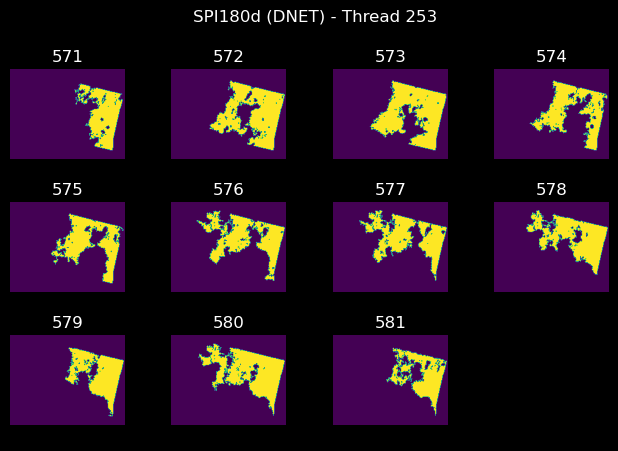

In [34]:
fig, axs = plt.subplots(3, 4)
axs_list = axs.ravel()

for i, arr in enumerate(select_array):
    ax = axs_list[i]
    ax.imshow(arr, vmin=0, vmax=1)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_title(571+i, color='w')

fig.set_facecolor('k')
fig.suptitle('SPI180d (DNET) - Thread 253', color='w')

plt.tight_layout()

while i < len(axs_list):
    axs_list[i].axis('off')
    i += 1

Now we can use our array to select out our original data as a mask

In [35]:
mask = np.ma.make_mask(select_array==0)
masked_array = np.ma.masked_where(mask, spi180d_data_xy_select.values)

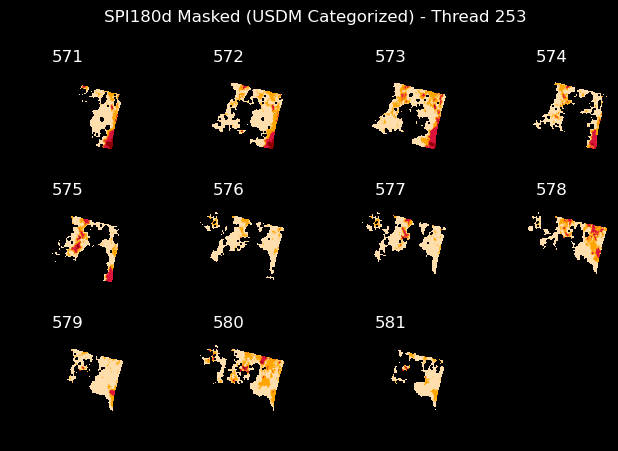

In [36]:
fig, axs = plt.subplots(3, 4)
axs_list = axs.ravel()

for i, arr in enumerate(masked_array):
    ax = axs_list[i]
    ax.imshow(arr, vmin=-1, vmax=4, cmap=ndplot.usdm_cmap())
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_title(571+i, color='w')

fig.set_facecolor('k')
fig.suptitle('SPI180d Masked (USDM Categorized) - Thread 253', color='w')

plt.tight_layout()

while i < len(axs_list):
    axs_list[i].axis('off')
    i += 1

And there are our drought blobs! Now if we want to convert back to lat/lon, you can reproject the output from the drought network in a dataarray back to EPSG:4326 and then do the masking, but I'll leave that as an exercise for you to do.

If we want, we can even animate this:

In [37]:
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython import display
from IPython.display import HTML

In [38]:
plt.rcParams["animation.html"] = "html5"

In [39]:
fig, ax = plt.subplots(figsize=(10,5))

#ax.axis('off')
#fig.set_facecolor('k')

def animate(i):
    ax.clear()
    ax.invert_yaxis()
    ax.set_facecolor('k')
    ax.set_aspect('equal')
    ax.set_title(np.datetime_as_string(spi180d_data_xy_select['time'].values[i])[:10])
    return (ax.pcolormesh(masked_array[i,:,:], cmap=ndplot.usdm_cmap(), vmin=-1, vmax=4),)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=11, blit=True)
video = ani.to_jshtml()
html = display.HTML(video)
display.display(html)
plt.close()

And that's where I'll leave off with this tutorial. There are a variety of ways you can take advantage of the indexing to manipulate the network, and I hope this notebook serves you well in your `DroughtNetwork` adventures. I encourage you to try some of the plotting functions in the script to see what they look like and determine if they are right for you.